In [28]:
import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from bayes_ts_funcs import generate_gam, gam_input
tfd = tfp.distributions

[0.07692308 0.15384616 0.23076923 0.30769232 0.3846154  0.46153846
 0.53846157 0.61538464 0.6923077  0.7692308  0.84615386 0.9230769 ]


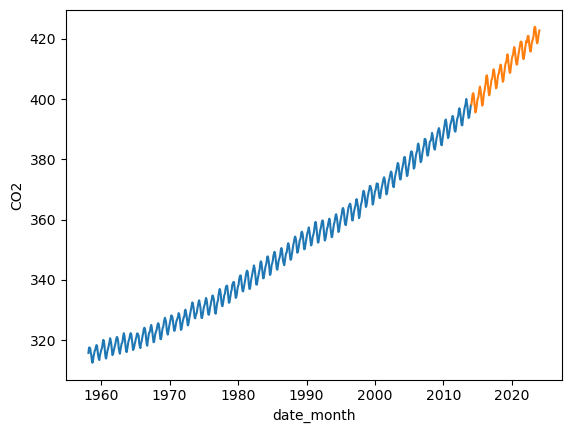

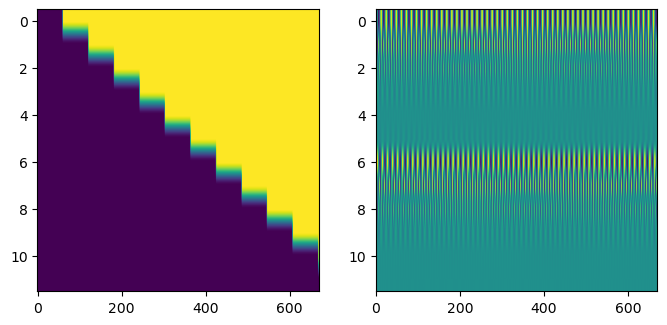

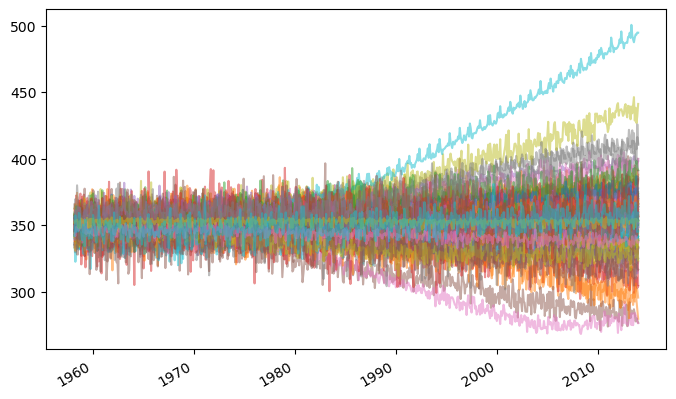

In [26]:
co2_by_month = pd.read_csv("co2_mm_mlo.csv",comment='#')
co2_by_month["date_month"] = pd.to_datetime(
    co2_by_month["year"].astype("str")
    .str.cat(['-']*co2_by_month.shape[0])
    .str.cat(co2_by_month["month"].astype("str"))
)
co2_by_month["CO2"] = co2_by_month["average"].astype(np.float32)
co2_by_month.set_index("date_month", drop=True, inplace=True)

num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
num_steps_all = co2_by_month.shape[0]
num_steps = num_steps_all - num_forecast_steps
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]
sns.lineplot(co2_by_month_training_data, x="date_month", y="CO2")
sns.lineplot(co2_by_month_testing_data, x="date_month", y="CO2")


# Get and display inputs
(X_cp_all, X_season_all, s), (X_cp, X_season, _) = gam_input(num_steps_all, num_forecast_steps)
fig,ax=plt.subplots(1,2, figsize=(8, 5))
ax[0].imshow(X_cp.T, aspect = X_cp.shape[0] / X_cp.shape[1])
ax[1].imshow(X_season.T, aspect = X_season.shape[0] / X_season.shape[1])
print(s)


# Get model and generate baselines
gam = generate_gam(
    X_cp_all,
    X_season_all,
    s,
    num_steps_all,
    num_forecast_steps,
    co2_by_month_training_data["CO2"].mean()
)
prior_samples = gam.sample(100)  
prior_predictive_timeseries = prior_samples.y_obs
t = co2_by_month.index[:-num_forecast_steps]
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t,tf.transpose(prior_samples.y_obs), alpha=.5)
fig.autofmt_xdate()

In [18]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False,
    jit_compile=True,
)
mcmc_samples, sampler_stats = run_mcmc(
    1000,
    gam,
    n_chains=4,
    num_adaptation_steps=1000,
    # Prepend batch index with [None]
    y_obs=co2_by_month_training_data["CO2"].values[None, ...]
)
regression_idata = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expects.
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)
regression_idata

2024-02-12 12:15:18.813696: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


Inference data with groups:
	> posterior
	> sample_stats

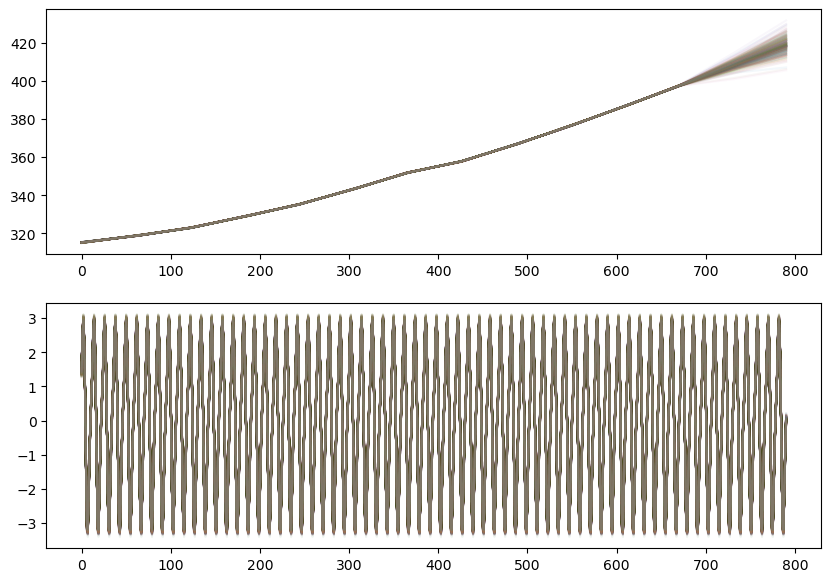

In [19]:
n_chain = regression_idata.posterior.dims["chain"]

k, m, tau, delta = mcmc_samples[1:5]

grow_rate = k[..., None] + tf.einsum('ij,...j->...i', X_cp_all, delta)
y_offset = m[..., None] + tf.einsum("ij,...j->...i", X_cp_all, -s * delta)

t = tf.cast(tf.linspace(0, 1, num_steps_all), np.float32)
y_trend = grow_rate * t + y_offset
y_season = tf.einsum('ij,...j->...i', X_season_all, mcmc_samples[0])


fig,ax = plt.subplots(2,1, figsize=(10, 7))
for i in range(regression_idata.posterior.dims["chain"]):
    ax[0].plot(y_trend[-100:,i,:].numpy().T, alpha=.05)
    ax[1].plot(y_season[-100:,i,:].numpy().T, alpha=.05)

/var/folders/mh/2xmd8gxn1g94m_ptkk4trpl40000gp/T/ipykernel_45856/3862210789.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


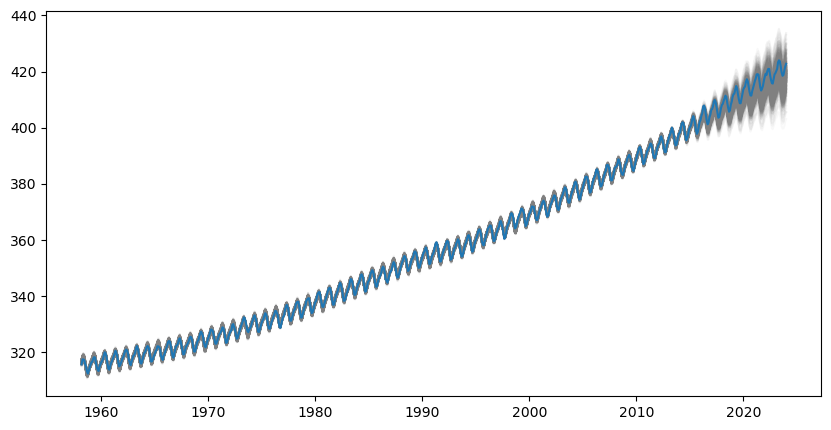

In [29]:
posterior_predictive_dist = tfd.Normal(y_trend+y_season, mcmc_samples.noise_sigma[..., None])
post_y_sample = tf.transpose(posterior_predictive_dist.sample())
post_y_sample.shape
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(co2_by_month.index, post_y_sample[:,2,:], color='grey', alpha=.05)
ax.plot(co2_by_month.index, co2_by_month["CO2"].values)
fig.show()